## 중요 사항

- ColumnTransformer 안의 단계에 접근: **named_transformers_** 속성 사용
- 선형 모델을 구간 분할하거나 다항식을 추가하면 성능이 향상됨
- 구간 분할: KBinsDiscretizer(n_ibns=10, strategy='uniform', encode='onehot-dense')
- 원래 특성에 다항식 추가: PloynomialFeatures(degree=10, include_bias=False)
- 트리 기반 모델의 max_features 매개변수는 트리의 각 분기에서 사용될 후보 특성의 개수를 제한한다. 따라서 특성의 나열 순서가 결과에 영향을 줄 수 있다.
- 선형 모델과 신경망은 각 특성의 스케일 및 분포와 밀접하게 연관되어 있다. 특성과 타깃 값 사이에 비선형성이 있다면 특히 선형 회귀에서는 모델을 만들기 어렵다. 
- 데이터 스케일 변경에 log, exp 함수 사용한다. 대부분의 모델은 각 특성이 (회귀에서는 타깃도) 정규분포와 비슷할 때 최고의 성능을 낸다.
- sin, cos 함수는 주기적인 패턴이 들어 있는 데이터를 다룰 때 편리하다

In [75]:
from preamble import *

## 4.1 범주형 변수

### 4.1.1 원-핫-인코딩 (가변수)

In [76]:
import os
# 이 파일은 열 이름을 나타내는 헤더가 없으므로 header=None으로 지정하고
# "names" 매개변수로 열 이름을 제공합니다
data = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_PATH, "adult.data"), header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
# 예제를 위해 몇개의 열만 선택합니다
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
data.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


#### 문자열로 된 범주형 데이터 확인하기

In [77]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


In [78]:
print("원본 특성:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("get_dummies 후의 특성:\n", list(data_dummies.columns))

원본 특성:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

get_dummies 후의 특성:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ 

In [79]:
data_dummies.head()

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,...,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,...,0,0,1,0
1,50,13,0,0,...,0,0,1,0
2,38,40,0,0,...,0,0,1,0
3,53,40,0,0,...,0,0,1,0
4,28,40,0,0,...,0,0,1,0


In [80]:
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']
# NumPy 배열 추출
X = features.values
y = data_dummies['income_ >50K'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (32561, 44)  y.shape: (32561,)


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))

테스트 점수: 0.81


### 4.1.2 숫자로 표현된 범주형 특성

In [82]:
# 숫자 특성과 범주형 문자열 특성을 가진 DataFrame을 만듭니다
demo_df = pd.DataFrame({'숫자 특성': [0, 1, 2, 1],
                        '범주형 특성': ['양말', '여우', '양말', '상자']})
demo_df

,숫자 특성,범주형 특성
0,0,양말
1,1,여우
2,2,양말
3,1,상자


In [83]:
pd.get_dummies(demo_df)

,숫자 특성,범주형 특성_상자,범주형 특성_양말,범주형 특성_여우
0,0,0,1,0
1,1,0,0,1
2,2,0,1,0
3,1,1,0,0


In [84]:
demo_df['숫자 특성'] = demo_df['숫자 특성'].astype(str)
pd.get_dummies(demo_df, columns=['숫자 특성', '범주형 특성'])

,숫자 특성_0,숫자 특성_1,숫자 특성_2,범주형 특성_상자,범주형 특성_양말,범주형 특성_여우
0,1,0,0,0,1,0
1,0,1,0,0,0,1
2,0,0,1,0,1,0
3,0,1,0,1,0,0


## 4.2 OneHotEncoder와 ColumnTransformer: scikit-learn으로 범주형 변수 다루기

In [85]:
from sklearn.preprocessing import OneHotEncoder
# sparse=False로 설정하면 OneHotEncode가 희소 행렬이 아니라 넘파이 배열을 반환합니다
ohe = OneHotEncoder(sparse=False)
print(ohe.fit_transform(demo_df))

[[1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0.]]


In [86]:
# get_feature_names() 메서드가 1.0에서 deprecated 되었고 1.2 버전에서 삭제될 예정입니다.
# 대신 get_feature_names_out()을 사용합니다.
print(ohe.get_feature_names_out())

['숫자 특성_0' '숫자 특성_1' '숫자 특성_2' '범주형 특성_상자' '범주형 특성_양말' '범주형 특성_여우']


In [87]:
data.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer(
    [("scaling", StandardScaler(), ['age', 'hours-per-week']),
     ("onehot", OneHotEncoder(sparse=False), 
      ['workclass', 'education', 'gender', 'occupation'])])

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# income을 제외한 모든 열을 추출합니다
data_features = data.drop("income", axis=1)
# 데이터프레임과 incom을 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data.income, random_state=0)

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(24420, 44)


In [90]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
print("테스트 점수: {:.2f}".format(logreg.score(X_test_trans, y_test)))

테스트 점수: 0.81


In [91]:
ct.named_transformers_.onehot

OneHotEncoder(sparse=False)

## 4.3 make_column_transformer로 간편하게 ColumnTransformer 만들기

In [92]:
from sklearn.compose import make_column_transformer
ct = make_column_transformer(
    (StandardScaler(), ['age', 'hours-per-week']),
    (OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation']))

## 4.4 구간 분할, 이산화 그리고 선형 모델, 트리 모델

선형 모델이나 나이브 베이즈 모델 같은 덜 복잡한 모델은 구간 분할, 다항식, 상호작용에 큰 영향을 받을 수 있다.

트리 기반 모델은 스스로 중요한 상호작용을 찾아낼 수 있고 대부분의 경우 데이터를 명시적으로 변환하지 않아도 된다.

SVM, 최근접 이웃, 신경망 같은 모델은 이따금 구간 분할, 상호작용, 다항식으로 이득을 볼 수 있지만 선형 모델보다는 영향이 그렇게 뚜렷하지 않다.

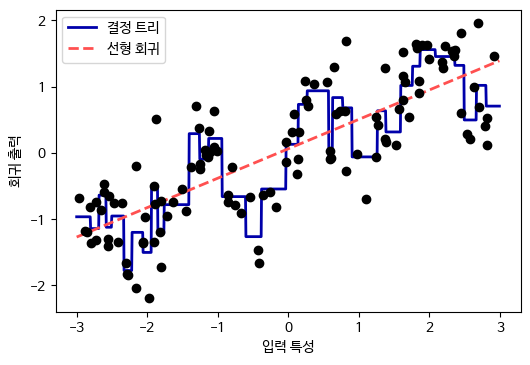

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label="결정 트리")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), '--', label="선형 회귀")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.legend(loc="best")
plt.show() # 책에는 없음

In [94]:
from sklearn.preprocessing import KBinsDiscretizer

In [95]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)
print("bin edges: \n", kb.bin_edges_)

bin edges: 
 [array([-2.967, -2.378, -1.789, -1.2  , -0.612, -0.023,  0.566,  1.155,
         1.744,  2.333,  2.921])                                       ]


In [96]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

In [97]:
print(X[:10])
X_binned.toarray()[:10]

[[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]
 [-2.064]
 [-2.651]
 [ 2.197]
 [ 0.607]
 [ 1.248]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [98]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

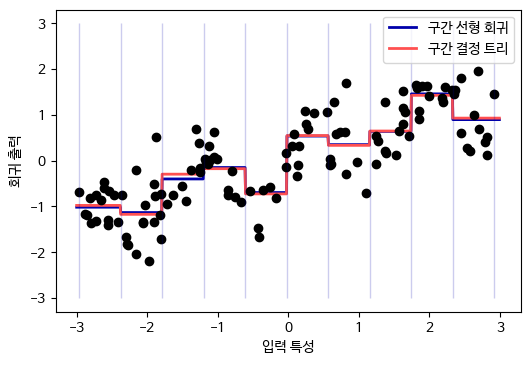

In [99]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='구간 선형 회귀')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='구간 결정 트리')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.show() # 책에는 없음

## 4.5 상호작용(interaction)과 다항식(polynomial)

- 절편 뿐만 아니라 기울기도 학습
- 선형 모델에 기울기를 추가하는 방법: 구간으로 분할된 데이터에 원래 특성을 다시 추가

In [100]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(120, 11)


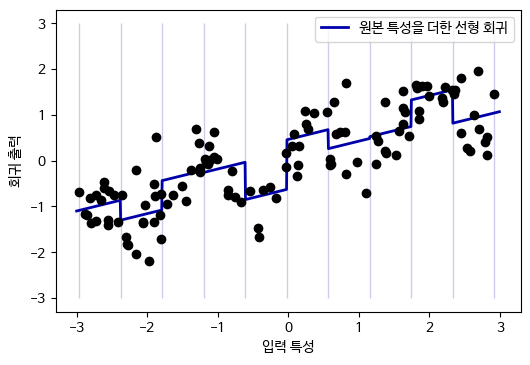

In [101]:
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='원본 특성을 더한 선형 회귀')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.plot(X[:, 0], y, 'o', c='k')
plt.show() # 책에는 없음

In [102]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(120, 20)


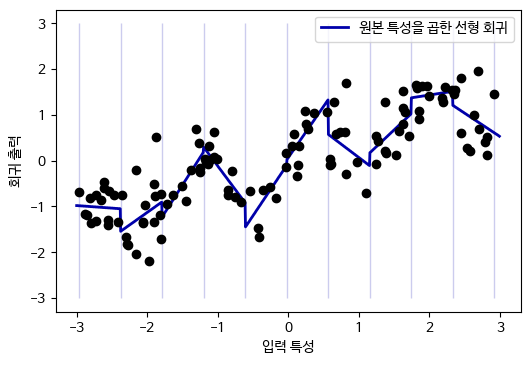

In [103]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='원본 특성을 곱한 선형 회귀')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.legend(loc="best")
plt.show() # 책에는 없음

In [104]:
from sklearn.preprocessing import PolynomialFeatures

# x ** 10까지 고차항을 추가합니다
# 기본값인 "include_bias=True"는 절편에 해당하는 1인 특성을 추가합니다
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

In [105]:
print("X_poly.shape:", X_poly.shape)

X_poly.shape: (120, 10)


In [106]:
print("X 원소:\n", X[:5])
print("X_poly 원소:\n", X_poly[:5])

X 원소:
 [[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]]
X_poly 원소:
 [[   -0.753     0.567    -0.427     0.321    -0.242     0.182    -0.137
      0.103    -0.078     0.058]
 [    2.704     7.313    19.777    53.482   144.632   391.125  1057.714
   2860.36   7735.232 20918.278]
 [    1.392     1.938     2.697     3.754     5.226     7.274    10.125
     14.094    19.618    27.307]
 [    0.592     0.35      0.207     0.123     0.073     0.043     0.025
      0.015     0.009     0.005]
 [   -2.064     4.26     -8.791    18.144   -37.448    77.289  -159.516
    329.222  -679.478  1402.367]]


In [107]:
# get_feature_names() 메서드가 1.0에서 deprecated 되었고 1.2 버전에서 삭제될 예정입니다.
# 대신 get_feature_names_out()을 사용합니다.
print("항 이름:\n", poly.get_feature_names_out())

항 이름:
 ['x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5' 'x0^6' 'x0^7' 'x0^8' 'x0^9' 'x0^10']


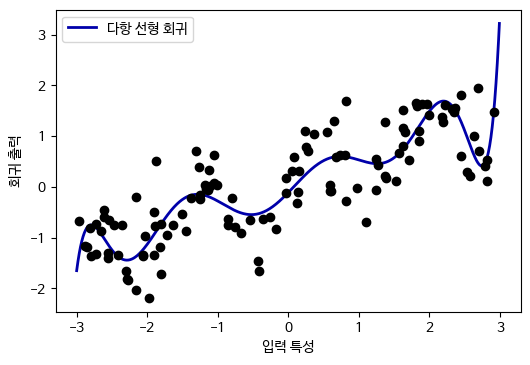

In [108]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='다항 선형 회귀')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.legend(loc="best")
plt.show() # 책에는 없음

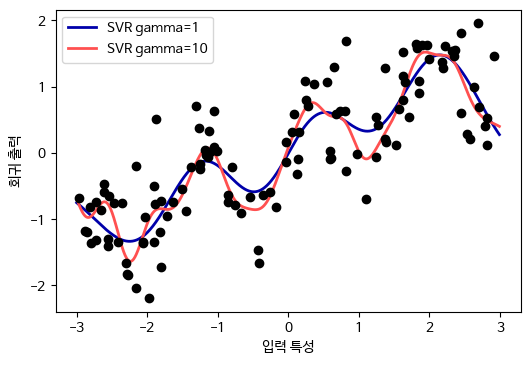

In [109]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.legend(loc="best")
plt.show() # 책에는 없음

In [110]:
# 보스턴 주택 데이터셋이 1.0 버전에 deprecated 되었고 1.2 버전에서 삭제됩니다.
# 경고 메시지를 피하기 위해 다음 코드를 추가합니다.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

# 데이터 스케일 조정
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [111]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape:", X_train.shape)
print("X_train_poly.shape:", X_train_poly.shape)

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


In [112]:
# get_feature_names() 메서드가 1.0에서 deprecated 되었고 1.2 버전에서 삭제될 예정입니다.
# 대신 get_feature_names_out()을 사용합니다.
print("다항 특성 이름:\n", poly.get_feature_names_out())

다항 특성 이름:
 ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12'
 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x0 x8'
 'x0 x9' 'x0 x10' 'x0 x11' 'x0 x12' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5'
 'x1 x6' 'x1 x7' 'x1 x8' 'x1 x9' 'x1 x10' 'x1 x11' 'x1 x12' 'x2^2' 'x2 x3'
 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7' 'x2 x8' 'x2 x9' 'x2 x10' 'x2 x11'
 'x2 x12' 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x3 x8' 'x3 x9' 'x3 x10'
 'x3 x11' 'x3 x12' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7' 'x4 x8' 'x4 x9' 'x4 x10'
 'x4 x11' 'x4 x12' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x8' 'x5 x9' 'x5 x10'
 'x5 x11' 'x5 x12' 'x6^2' 'x6 x7' 'x6 x8' 'x6 x9' 'x6 x10' 'x6 x11'
 'x6 x12' 'x7^2' 'x7 x8' 'x7 x9' 'x7 x10' 'x7 x11' 'x7 x12' 'x8^2' 'x8 x9'
 'x8 x10' 'x8 x11' 'x8 x12' 'x9^2' 'x9 x10' 'x9 x11' 'x9 x12' 'x10^2'
 'x10 x11' 'x10 x12' 'x11^2' 'x11 x12' 'x12^2']


In [113]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("상호작용 특성이 없을 때 점수: {:.3f}".format(ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("상호작용 특성이 있을 때 점수: {:.3f}".format(ridge.score(X_test_poly, y_test)))

상호작용 특성이 없을 때 점수: 0.621
상호작용 특성이 있을 때 점수: 0.753


In [114]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_scaled, y_train)
print("상호작용 특성이 없을 때 점수: {:.3f}".format(rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_poly, y_train)
print("상호작용 특성이 있을 때 점수: {:.3f}".format(rf.score(X_test_poly, y_test)))

상호작용 특성이 없을 때 점수: 0.795
상호작용 특성이 있을 때 점수: 0.775


## 4.6 일변량 비선형 변환

"사용자가 얼마나 자주 로그인하는가?"와 같은 정수 카운트 데이터의 전형적인 분포는 푸아송(Poisson) 분포이다. 푸아송 분포는 단위 시간 안에 일어나는 이벤트 횟수를 표현하는 확률 분포이다.

한쪽으로 치우친 데이터를 로그 스케일로 변환하면 성능이 좋아진다.

In [115]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)
print(X[:10, 0])

[ 56  81  25  20  27  18  12  21 109   7]


In [116]:
print("특성 출현 횟수:\n", np.bincount(X[:, 0]))

특성 출현 횟수:
 [28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


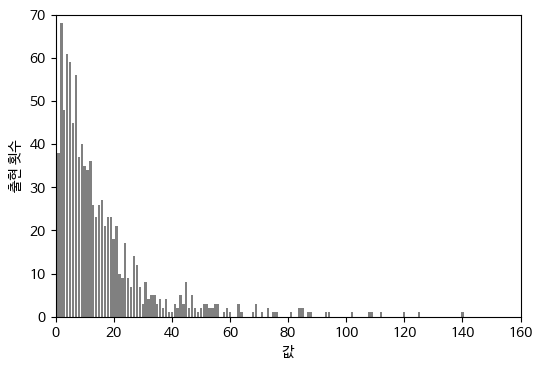

In [117]:
plt.xlim(0, 160)
plt.ylim(0, 70)
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='grey')
plt.ylabel("출현 횟수")
plt.xlabel("값")
plt.show() # 책에는 없음

In [118]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("테스트 점수: {:.3f}".format(score))

테스트 점수: 0.622


In [119]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

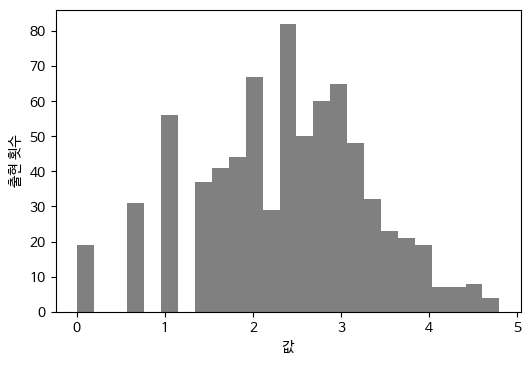

In [120]:
plt.hist(X_train_log[:, 0], bins=25, color='gray')
plt.ylabel("출현 횟수")
plt.xlabel("값")
plt.show() # 책에는 없음

In [121]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("테스트 점수: {:.3f}".format(score))

테스트 점수: 0.875


## 4.7 특성 자동 선택

일변량 통계(univariate statistics), 모델 기반 선택(model-based selection), 반복적 선택(iterative selection)

### 4.7.1 일변량 통계(univariate statistics)

개개의 특성과 타깃 사이에 중요한 통계적 관계가 있는지 계산한다. 분산분석이라고도 한다. **분산분석**은 데이터를 클래스별로 나누어 평균을 비교하는 방법이다. 분산분석으로 계산한 어떤 특성의 F-값이 높으면 그 특성은 클래스별로 평균이 서로 다르다는 뜻이다.

이 방법의 핵심 요소는 일변량, 즉 각 특성이 독립적으로 평가된다는 점이다. 

분류에서는 f_classif를 사용하여 테스트한 뒤 percentile에 지정한 비율만큼만 선택: SelectPercentile(score_func=f_classif, percentile=50)

In [122]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# 고정된 난수를 발생시킵니다
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# 데이터에 노이즈 특성을 추가합니다
# 처음 30개는 원본 특성이고 다음 50개는 노이즈입니다
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# f_classif(기본값)와 SelectPercentile을 사용하여 특성의 50%를 선택합니다
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)
# 훈련 세트에 적용합니다
X_train_selected = select.transform(X_train)

print("X_train.shape:", X_train.shape)
print("X_train_selected.shape:", X_train_selected.shape)

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


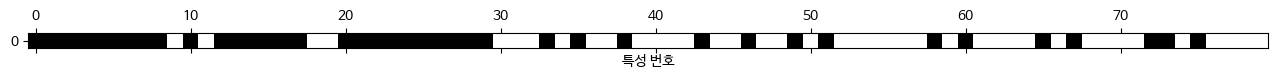

In [123]:
mask = select.get_support()
print(mask)
# True는 검은색, False는 흰색으로 마스킹합니다
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("특성 번호")
plt.yticks([0])
plt.show() # 책에는 없음

In [124]:
from sklearn.linear_model import LogisticRegression

# 테스트 데이터 변환
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
print("전체 특성을 사용한 점수: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("선택된 일부 특성을 사용한 점수: {:.3f}".format(
        lr.score(X_test_selected, y_test)))

전체 특성을 사용한 점수: 0.947
선택된 일부 특성을 사용한 점수: 0.933


### 4.7.2 모델 기반 특성 선택

지도 학습 머신러닝 모델을 사용하여 특성의 중요도를 평가해서 가장 중요한 특성들만 선택한다. 특성 선택에 사용하는 지도 학습 모델과 최정 사용 지도 학습 모델이 같을 필요는 없다.

일변량 분석과는 반대로 한 번에 모든 특성을 고려하므로 (사용된 모델이 상호작용을 잡아낼 수 있다면) 상호작용 부분을 반영할 수 있다. 

SelectFromModel은 (지도 학습 모델로 계산된) 중요도가 지정한 임계치보다 큰 모든 특성을 선택한다.

In [125]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

In [126]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape:", X_train.shape)
print("X_train_l1.shape:", X_train_l1.shape)

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


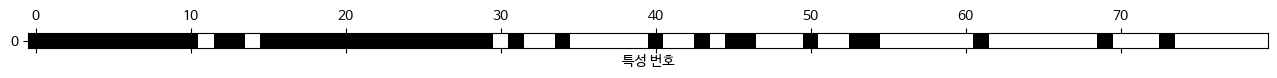

In [127]:
mask = select.get_support()
# True는 검은색, False는 흰색으로 마스킹합니다
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("특성 번호")
plt.yticks([0])
plt.show() # 책에는 없음

In [128]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=5000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("테스트 점수: {:.3f}".format(score))

테스트 점수: 0.947


### 4.7.3 반복적 특성 선택(Iterative Feature Selection)

- 전진 선택법(forward stepwise selection)
- 후진 제거법(backward stepwise selection)
- SequentialFeatureSelector 클래스는 scoring 매개변수에 지정된 측정 지표의 교차 검증 점수를 기준으로 특성을 하나씩 제거하거나 추가한다. [공식 문서](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html){target=_blank}

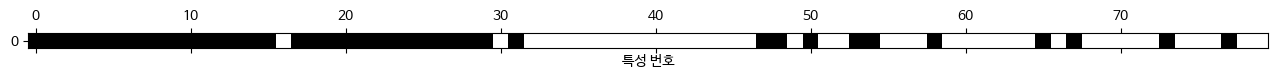

In [129]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# 선택된 특성을 표시합니다
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("특성 번호")
plt.yticks([0])
plt.show() # 책에는 없음

In [130]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("테스트 점수: {:.3f}".format(score))

테스트 점수: 0.940


In [131]:
print("테스트 점수: {:.3f}".format(select.score(X_test, y_test)))

테스트 점수: 0.951


## 4.8 전문가 지식 활용

In [132]:
citibike = mglearn.datasets.load_citibike()

In [133]:
print("시티 바이크 데이터:\n", citibike.head())

시티 바이크 데이터:
 starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


#### X 축에 날짜 요일 표시하기

pd.data_range(start=datetime-like, end=datetime-like, freq='Date/Month/Hour/...')


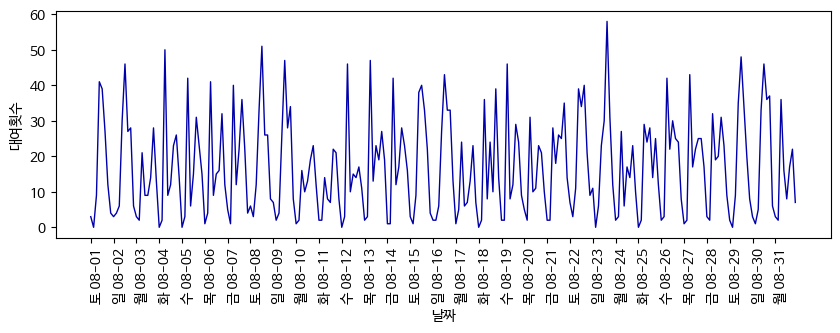

In [134]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
week = ["일", "월", "화","수", "목", "금", "토"]
xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime("%w"), 
                                              xticks.strftime(" %m-%d"))]
plt.xticks(xticks, xticks_name, rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("날짜")
plt.ylabel("대여횟수")
plt.show() # 책에는 없음

In [135]:
# 타깃값 추출 (대여 횟수)
y = citibike.values
# 판다스 1.3.0에서 datetime을 astype()으로 정수로 바꾸는 것이 deprecated되었고 향후 삭제될 예정입니다.
# 대신 view()를 사용합니다.
# POSIX 시간을 10**9로 나누어 변경
X = citibike.index.view("int64").reshape(-1, 1) // 10**9

In [136]:
# 처음 184개 데이터 포인트를 훈련 세트로 사용하고 나머지는 테스트 세트로 사용합니다
n_train = 184

# 주어진 특성을 사용하여 평가하고 그래프를 만듭니다
def eval_on_features(features, target, regressor):
    # 훈련 세트와 테스트 세트로 나눕니다
    X_train, X_test = features[:n_train], features[n_train:]
    # 타깃값도 나눕니다
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("테스트 세트 R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="훈련")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="테스트")
    plt.plot(range(n_train), y_pred_train, '--', label="훈련 예측")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="테스트 예측")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("날짜")
    plt.ylabel("대여횟수")

테스트 세트 R^2: -0.04


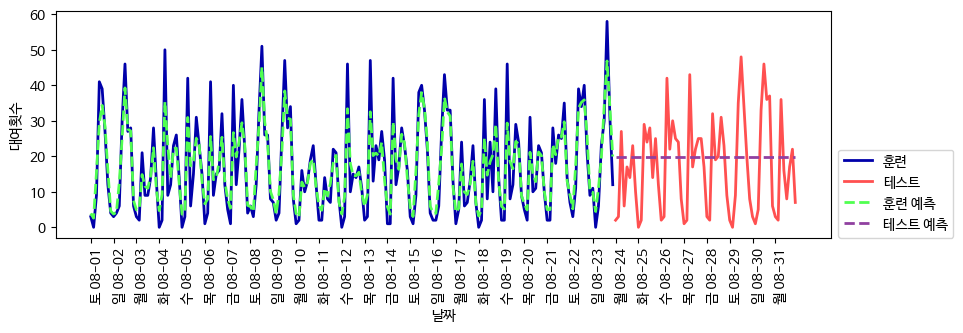

In [137]:
 regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

테스트 세트 R^2: 0.60


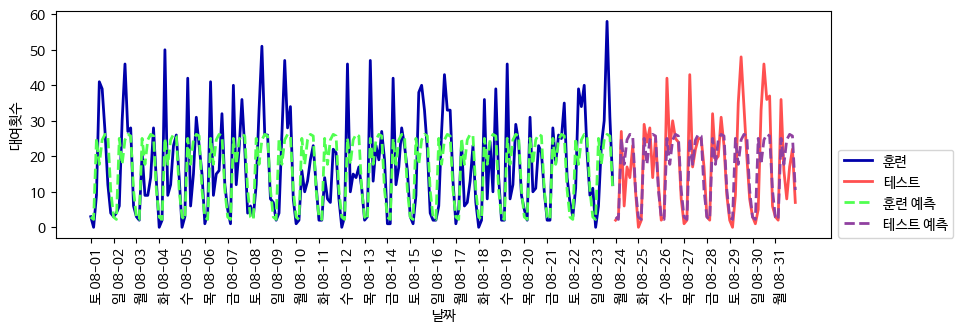

In [138]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

테스트 세트 R^2: 0.84


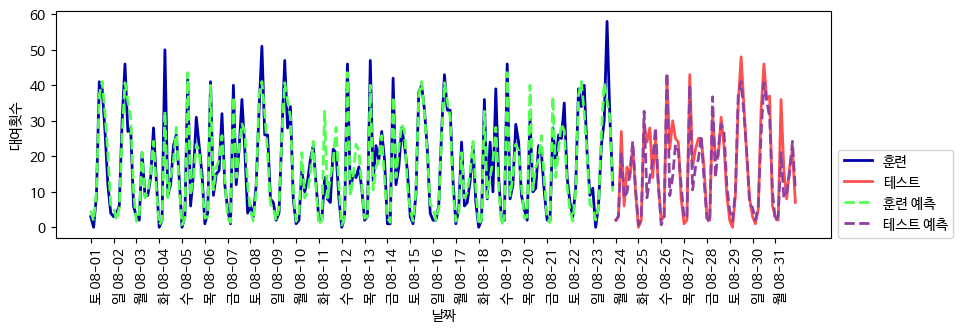

In [139]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

테스트 세트 R^2: 0.13


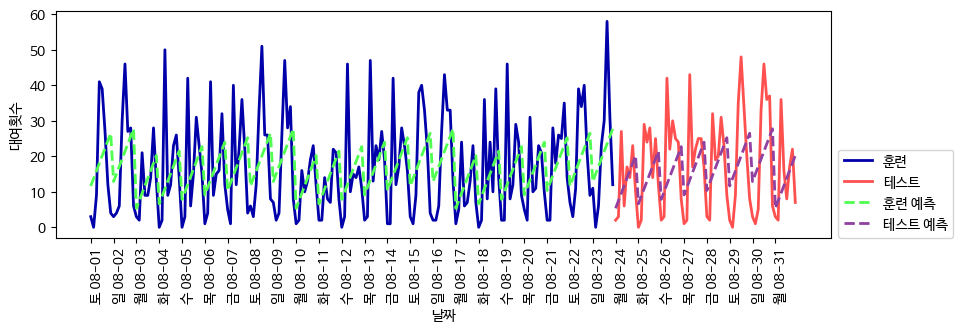

In [140]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

scikit-learn 0.22 버전에서 OneHotEncoder 클래스가 정수 카테고리를 인식하는 방식이 변경됩니다. 이전에는 훈련 데이터에 나타난 0~최댓값 사이 범위를 카테고리로 인식하여 원-핫 인코딩하지만 0.22 버전부터는 고유한 정수 값을 카테고리로 사용합니다. 0.20 버전부터 정수형 데이터를 변환할 때 이와 관련된 경고가 출력됩니다.

In [141]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

테스트 세트 R^2: 0.62


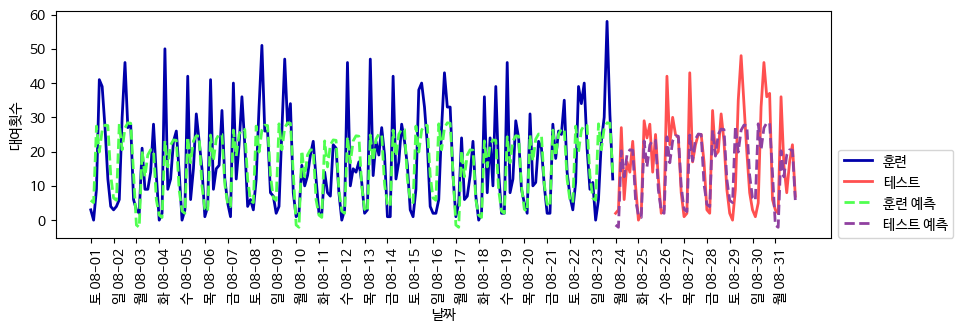

In [142]:
eval_on_features(X_hour_week_onehot, y, Ridge())

테스트 세트 R^2: 0.85


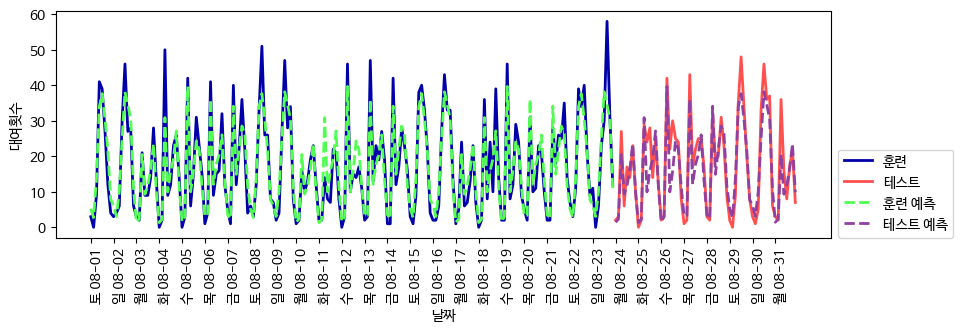

In [143]:
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [144]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["월", "화", "수", "목", "금", "토", "일"]
features =  day + hour

In [145]:
# get_feature_names() 메서드가 1.0에서 deprecated 되었고 1.2 버전에서 삭제될 예정입니다.
# 대신 get_feature_names_out()을 사용합니다.
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

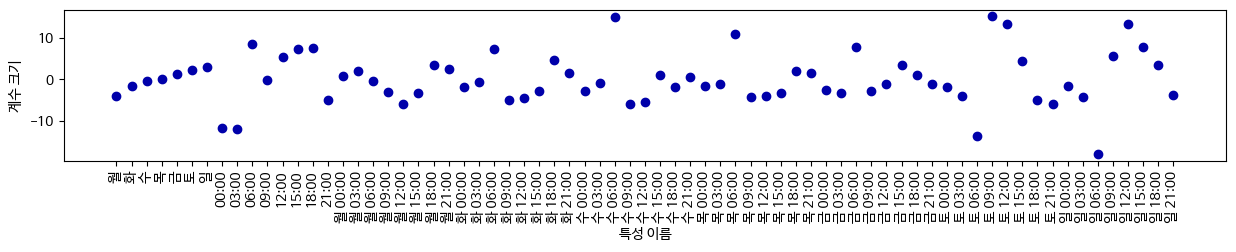

In [146]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("특성 이름")
plt.ylabel("계수 크기")
plt.show() # 책에는 없음